<a href="https://colab.research.google.com/github/brandontan99/Self_Love_App/blob/master/Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
%cd /content
!git clone https://github.com/brandontan99/Self_Love_App.git
%cd /content/Self_Love_App
!pip install scikit-multilearn

from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from skmultilearn.adapt import *
from skmultilearn.problem_transform import *
from skmultilearn.ensemble import * 
from skmultilearn.cluster import *
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
import pandas as pd
from scipy import sparse
import numpy as np
import matplotlib.pyplot as plt
import time

from data_cleaning import data_cleaning
from Data_Normalization import data_encoding, data_normalization
from feature_selection import *

# random seed
seed = 1

/content
Cloning into 'Self_Love_App'...
remote: Enumerating objects: 175, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 175 (delta 96), reused 50 (delta 22), pack-reused 0
Receiving objects: 100% (175/175), 1.84 MiB | 13.36 MiB/s, done.
Resolving deltas: 100% (96/96), done.
/content/Self_Love_App
     |████████████████████████████████| 92kB 4.1MB/s 


# Data Preparation

In [9]:
df = pd.read_csv("WID3006 ML Questionnaire.csv")
df_cleaned = data_cleaning(df)
df_encoded = data_encoding(df_cleaned)
df_norm = data_normalization(df_encoded)
df_norm

,Gender: _Male,What is your current occupation?_Retired,What is your current occupation?_Unemployed,What is your current occupation?_University student,What boosts your confidence ? _By leading others to success,What boosts your confidence ? _Get the most/ special attention among the members,What boosts your confidence ? _When someone acknowledges you,What boosts your confidence ? _When you accomplish a project,I prefer to spend my money on...._Food,I prefer to spend my money on...._Home Improvements,I prefer to spend my money on...._The latest fashion,I prefer to spend my money on...._The latest technology,How do you organize your thoughts? Please pick whichever is closest._I make a chart or graph,How do you organize your thoughts? Please pick whichever is closest._I talk to myself out loud,How do you organize your thoughts? Please pick whichever is closest._I write it down in my calendar,How do you organize your thoughts? Please pick whichever is closest._Jotting it down on a scrap of paper,Choose a pet which you prefer to keep._Cat,Choose a pet which you prefer to keep._Dog,Choose a pet which you prefer to keep._Fish,Choose a pet which you prefer to keep._Hamster,Choose a pet which you prefer to keep._Horse,Choose a pet which you prefer to keep._I'm not a pet person,Choose a pet which you prefer to keep._Rabbit,Choose a pet which you prefer to keep._Snake,Choose a pet which you prefer to keep._Tortoise,What is your favorite time of the day?_Evening,What is your favorite time of the day?_Morning,What is your favorite time of the day?_Night,Would you rather visit the future or the past?_The future,Would you rather visit the future or the past?_The past,What do you worry more about the most?_Money,What do you worry more about the most?_The state of the world,What do you worry more about the most?_Your family and friends,What do you worry more about the most?_Your future,"When you retire, you'd like to live..._Exactly where I live now","When you retire, you'd like to live..._In a hectic big city","When you retire, you'd like to live..._In a small town","When you retire, you'd like to live..._Overseas","When you retire, you'd like to live..._Traveling the world",What is your favorite color?_Blue,What is your favorite color?_Green,What is your favorite color?_Purple,What is your favorite color?_Red,What is your favorite color?_White,What is your favorite color?_Yellow,What is your learning style? (Pick one that benefit you the most)_By attending online courses,What is your learning style? (Pick one that benefit you the most)_By doing assignments,What is your learning style? (Pick one that benefit you the most)_By doing tutorial/lab questions,What is your learning style? (Pick one that benefit you the most)_By reading a physical book,What is your learning style? (Pick one that benefit you the most)_By reading an e-Book,Do you enjoy socializing with large groups of people?,Do you enjoy challenges?,How creative of a person do you think you are?,How logical of a person do you think you are?,Would you prefer to engage your brain more than your body?,Are you a curious person?,Are you a perfectionist?,Are you a trusting person?,Do you have lot of patience?,Do you organize your schedule well?,Do you like to sit in front of a computer for long hours?,Do you enjoy making others happy?,Can you understand others' perspectives and feelings?,How confident are you in your own abilities?,Sports and Outdoors,Games,Spiritual and Mental,Performing Arts,Arts and Craft,Food and Drinks,Collecting,Rejuvenation
0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0.25,0.50,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,1.00,0.75,0.50,0.50,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0.75,0.75,0.75,0.75,0.50,1.00,1.00,0.50,0.75,0.75,0.75,1.00,0.75,1.00,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,

In [5]:
for i, name in enumerate(df_norm.columns):
  print(i, name)

0 Gender: _Male
1 What is your current occupation?_Retired
2 What is your current occupation?_Unemployed
3 What is your current occupation?_University student
4 What boosts your confidence ? _By leading others to success
5 What boosts your confidence ? _Get the most/ special attention among the members
6 What boosts your confidence ? _When someone acknowledges you
7 What boosts your confidence ? _When you accomplish a project
8 I prefer to spend my money on...._Food
9 I prefer to spend my money on...._Home Improvements
10 I prefer to spend my money on...._The latest fashion
11 I prefer to spend my money on...._The latest technology
12 How do you organize your thoughts? Please pick whichever is closest._I make a chart or graph
13 How do you organize your thoughts? Please pick whichever is closest._I talk to myself out loud
14 How do you organize your thoughts? Please pick whichever is closest._I write it down in my calendar
15 How do you organize your thoughts? Please pick whichever is 

In [32]:
x = filter_features(best_k_features, df_norm)
x

,Gender: _Male,What is your current occupation?_Retired,What is your current occupation?_Unemployed,What is your current occupation?_University student,What boosts your confidence ? _By leading others to success,What boosts your confidence ? _Get the most/ special attention among the members,What boosts your confidence ? _When someone acknowledges you,What boosts your confidence ? _When you accomplish a project,I prefer to spend my money on...._Food,I prefer to spend my money on...._Home Improvements,I prefer to spend my money on...._The latest fashion,I prefer to spend my money on...._The latest technology,How do you organize your thoughts? Please pick whichever is closest._I make a chart or graph,How do you organize your thoughts? Please pick whichever is closest._I talk to myself out loud,How do you organize your thoughts? Please pick whichever is closest._I write it down in my calendar,How do you organize your thoughts? Please pick whichever is closest._Jotting it down on a scrap of paper,Choose a pet which you prefer to keep._Cat,Choose a pet which you prefer to keep._Dog,Choose a pet which you prefer to keep._Fish,Choose a pet which you prefer to keep._Hamster,Choose a pet which you prefer to keep._Horse,Choose a pet which you prefer to keep._I'm not a pet person,Choose a pet which you prefer to keep._Rabbit,Choose a pet which you prefer to keep._Snake,Choose a pet which you prefer to keep._Tortoise,What is your favorite time of the day?_Evening,What is your favorite time of the day?_Morning,What is your favorite time of the day?_Night,Would you rather visit the future or the past?_The future,Would you rather visit the future or the past?_The past,What do you worry more about the most?_Money,What do you worry more about the most?_The state of the world,What do you worry more about the most?_Your family and friends,What do you worry more about the most?_Your future,"When you retire, you'd like to live..._Exactly where I live now","When you retire, you'd like to live..._In a hectic big city","When you retire, you'd like to live..._In a small town","When you retire, you'd like to live..._Overseas","When you retire, you'd like to live..._Traveling the world",What is your favorite color?_Blue,What is your favorite color?_Green,What is your favorite color?_Purple,What is your favorite color?_Red,What is your favorite color?_White,What is your favorite color?_Yellow,What is your learning style? (Pick one that benefit you the most)_By attending online courses,What is your learning style? (Pick one that benefit you the most)_By doing assignments,What is your learning style? (Pick one that benefit you the most)_By doing tutorial/lab questions,What is your learning style? (Pick one that benefit you the most)_By reading a physical book,What is your learning style? (Pick one that benefit you the most)_By reading an e-Book,Do you enjoy socializing with large groups of people?,Do you enjoy challenges?,How creative of a person do you think you are?,How logical of a person do you think you are?,Would you prefer to engage your brain more than your body?,Are you a perfectionist?,Do you have lot of patience?,Do you organize your schedule well?,Do you like to sit in front of a computer for long hours?,Do you enjoy making others happy?,How confident are you in your own abilities?
0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0.25,0.50,0.75,0.75,0.75,0.75,0.75,0.75,1.00,0.75,0.50
1,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0.75,0.75,0.75,0.75,0.50,1.00,0.75,0.75,0.75,1.00,1.00
2,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0.25,0.75,0.75,1.00,1.00,1.00,0.50,1.00,1.00,1.00,0.75
3,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0.75,0.75,0.50,0.75,0.50,0.75,0.75,0.75,0.75,0.75,0.75
4,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0

In [10]:
x = df_norm.iloc[:, :64]
y = df_norm.iloc[:, 64:]

In [11]:
x_numpy, y_numpy = x.to_numpy(), y.to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x_numpy, y_numpy, test_size=0.25, random_state=seed)
print("Number of train dataset:", len(x_train))
print("Number of test dataset:", len(x_test))

Number of train dataset: 144
Number of test dataset: 48


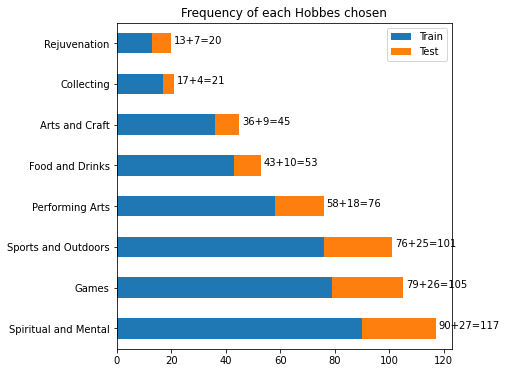

In [12]:
# draw the distribution of the hobbies with a horizontal bar chart
distribution_of_hobbies = y.sum().sort_values(ascending=False)
distribution_of_hobbies_train_test = pd.DataFrame(np.concatenate([y_train.sum(axis=0)[:,None], y_test.sum(axis=0)[:,None]], axis=1), index=y.columns, columns=["Train","Test"])
distribution_of_hobbies_train_test = distribution_of_hobbies_train_test.reindex(distribution_of_hobbies.index)
distribution_of_hobbies_train_test.plot(kind='barh', figsize=(6, 6), title="Frequency of each Hobbes chosen", stacked=True)

# put the frequency text on the right of the bar chart
for i, (row_index, row) in enumerate(distribution_of_hobbies_train_test.iterrows()):
  train_value = row["Train"]
  test_value = row["Test"]
  sum_value = train_value + test_value
  plt.text(x=sum_value+1 , y =i , s=f"{int(train_value)}+{int(test_value)}={int(sum_value)}" , fontdict=dict(fontsize=10))

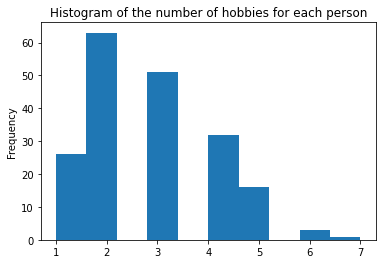

In [19]:
y.sum(axis=1).plot.hist(title='Histogram of the number of hobbies for each person')

# Models

In [5]:
# Base Classifiers ( dict format --> (name, func) : params )
base_models = {
    ("Decision_Tree", DecisionTreeClassifier) : {'min_samples_split':range(2,5) , 'min_samples_leaf':range(1,4),'min_weight_fraction_leaf':[0.0,0.5],'random_state':[seed]},
    ("Extra_Trees", ExtraTreesClassifier) : {'n_estimators':range(90,120,10),'min_samples_split':range(2,5) , 'min_samples_leaf':range(1,4),'n_jobs':[-1],'random_state':[seed]},
    ("Random_Forest", RandomForestClassifier) :{'n_estimators':range(90,120,10),'min_samples_split':range(2,5),'min_samples_leaf':range(1,4),'n_jobs':[-1],'random_state':[seed]},
    ("MLP", MLPClassifier) : {'hidden_layer_sizes': [(128,64,32),(64,32),(64)],'alpha':[1e-3, 1e-2, 1e-1], 'max_iter': [2000],'random_state':[seed]},
    ("Ridge", RidgeClassifierCV) : {'fit_intercept':[True]}
}

base_models_with_errors = {
    # Error: No neighbors found for test samples array (need to increase the radius size to 20, only can run)
    ("Radius_Neighbours", RadiusNeighborsClassifier) : {'radius':[1.0,1.5,2.0],'leaf_size':range(20,40),'p':range(1,3)},
}

# Adaptation approaches
adapt_models = {
    ("Binary_Relevance_kNN_A", BRkNNaClassifier) : {'k': range(1,3)},
    ("Binary_Relevance_kNN_B", BRkNNbClassifier) : {'k': range(1,3)},
    ("Multi-Label_KNN", MLkNN) : {'k': range(1,3), 's': [0.5, 0.7, 1.0]},
    ("ARAM_Neural_Network", MLARAM) : {'threshold':[0.05], 'vigilance':[0.95]},
    ("Twin_SVM", MLTSVM) : {'c_k': [2**i for i in range(-5, 5, 2)]} # need sparse input
}

# Problem Transformation
problem_transform = {
    "Binary_Relevance" : BinaryRelevance,
    "Classifier_Chain" : ClassifierChain,
    # "Label_Powerset" : LabelPowerset # too many output because 2^20 = 1048576
}

# Ensembles of Classifiers
emsemble_methods = {
    "Distinct_Random k-labtest" : RakelD,
    "Overlapping_Random_k-labtest" : RakelO,
    "Label_Space_Partitoning" : LabelSpacePartitioningClassifier,
    "Majoity_Voting" : MajorityVotingClassifier
}
# Multi-label embeddings (KIV)

# Hyperparameters

In [6]:
# Hyperparameters Tuning
num_of_kfold_splits = 5

# Training

### Adaptation approaches

In [13]:
results = {}
scoring = 'f1_micro'
y_sparse = sparse.csr_matrix(y_train)
x_sparse = sparse.csr_matrix(x_train)
for (model_name, model), params in adapt_models.items():
  kfold = KFold(n_splits=num_of_kfold_splits, random_state=None)
  clf = GridSearchCV(model(), params, cv=kfold, n_jobs=-1, scoring=scoring) # n_jobs=-1, << this cause error for some reason...
  if model_name == "Twin_SVM": # this model need sparse input
    clf.fit(x_sparse, y_sparse)
  else:
    clf.fit(x_train, y_train)
  results[model_name] = clf
  print(model_name,clf.best_score_)

Binary_Relevance_kNN_A 0.499234844568685
Binary_Relevance_kNN_B 0.2546153913758995
Multi-Label_KNN 0.5008165166572858
ARAM_Neural_Network 0.4984658444775036
Twin_SVM 0.5529060168298685


### Problem Transformation

In [ ]:
scoring = 'f1_micro'
x_train, x_test, y_train, y_test = train_test_split(x_numpy, y_numpy, test_size=0.2, random_state=seed)
# Random forest and ExtraTrees takes about 20 minutes each, if dw to wait, can just comment out these 2 algo in the dict above
for strategy_name, strategy in problem_transform.items():
  for (model_name, model), params in base_models.items():
    parameters = {}
    for param_name, param_value in params.items():
      parameters["classifier__"+param_name] = param_value
    kfold = KFold(n_splits=num_of_kfold_splits, random_state=None) 
    clf = GridSearchCV(strategy(classifier=model()), parameters, cv=kfold, n_jobs=-1, scoring=scoring) # n_jobs=-1, << this cause error for some reason...
    clf.fit(x_train, y_train)
    results[f"{strategy_name}_{model_name}"] = clf
    print(f"{strategy_name}_{model_name}",clf.best_score_)

Binary_Relevance_Decision_Tree 0.5185168368647163
Binary_Relevance_Extra_Trees 0.5354170812531904


### Ensembles of Classifiers (Under reconstruction)

#### Adaptation approaches

In [ ]:
def convertToParamsForProblemTransformation(base_models):
  parameters = []
  for (model_name, model), params in base_models.items():
    parameter = {}
    parameter["classifier"] = model()
    for param_name, param_value in params.items():
      paramter["classifier__"+param_name] = param_value
    parameters.append(parameter)

  return paramters

In [ ]:
scoring = 'f1_micro'
for emsemble_name, emsemble_method in emsemble_methods.items():
  for strategy_name, strategy in problem_transform.items():
    for base_model_name, base_model in base_models.items():
      kfold = KFold(n_splits=num_of_kfold_splits, random_state=seed)
      model = strategy(
              classifier = base_model(),
              require_dense = [False, True] # depens on the data is sparse or dense
      )
      cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, n_jobs=-1, scoring=scoring)
      results.append(cv_results)
      names.append(model_name)
      msg = "%s: %f (%f)" % (model_name, cv_results.mean(), cv_results.std())
      print(msg)
      classifier = MajorityVotingClassifier(
    clusterer = FixedLabelSpaceClusterer(clusters = [[1,3,4], [0, 2, 5]]),
    classifier = ClassifierChain(classifier=GaussianNB())
)
classifier.fit(X_train,y_train)
predictions = classifier.predict(X_test)

In [ ]:
classifier = MajorityVotingClassifier(
    clusterer = FixedLabelSpaceClusterer(clusters = [[1,3,4], [0, 2, 5]]),
    classifier = ClassifierChain(classifier=GaussianNB())
)
classifier.fit(X_train,y_train)


# Evaluation 

In [ ]:
def display_evaluation_result(results, y, x_test, y_test, distribution_of_hobbies_train_test, f1_average = "micro"):
  result_table = []
  for model_name, model in results.items():
    y_pred = model.predict(x_test)
    score = f1_score(y_test, y_pred, average=f1_average)
    score_by_class = f1_score(y_test, y_pred, average=None, zero_division=0)
    result_table.append([score]+score_by_class.tolist())

  # f1 score evaluation result overall and by class in percentage 
  # 0 means no True Positive at all or there is no example of that class in the y_text at all
  result_table_df = pd.DataFrame(result_table, columns=["Overall"]+y.columns.tolist(), index=results.keys()) * 100
  result_table_df.sort_values(by='Overall', inplace=True, ascending=False)

  # arrange the columns according to the frequency of each hobbies in the test set
  sorted_columns = distribution_of_hobbies_train_test["Test"].sort_values(ascending=False).index.tolist()
  modified_column_names = [column + "(" + str(int(distribution_of_hobbies_train_test.loc[column,"Test"]))+")" for column in sorted_columns]
  result_table_df = result_table_df[["Overall"] + sorted_columns] # sort the columns by the frequency of each hobbies in the test set 
  result_table_df.columns = [["Overall"] + modified_column_names] # add the frequency of each hobbies in the test set in the column name
  return result_table_df

display_evaluation_result(results, y, x_test, y_test, distribution_of_hobbies_train_test, f1_average = "micro")

# Outlier Removal
https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/

# Feature Selection

### Chi Square Analysis
https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/

In [27]:
# label encoding is used instead of one-hot encoding because one-hot encoding will create many features for one question
# but label encoding is able to perform chi-square test between a single question as a whole and the hobby  
x_df, y_df = label_encoding(df_cleaned)
# only evaluate on train data to prevent data leakage
x_train_label_encoded, _, y_train, _ = train_test_split(x_df.to_numpy(), y_df.to_numpy(), test_size=0.2, random_state=seed)
chi2_result = chi2_analysis(x_train_label_encoded, x_df, y_train)
chi2_result

,0
Gender:,3.770253
What is your favorite color?,2.721663
How do you organize your thoughts? Please pick whichever is closest.,1.865759
What is your learning style? (Pick one that benefit you the most),1.262605
Choose a pet which you prefer to keep.,1.237745
"When you retire, you'd like to live...",1.140896
How confident are you in your own abilities?,1.047536
Do you enjoy socializing with large groups of people?,1.025456
Do you like to sit in front of a computer for long hours?,0.964861
Do you organize your schedule well?,0.894733


##### Evaluation

In [29]:
params = base_models[("Extra_Trees", ExtraTreesClassifier)]
params = {"classifier__"+param_name:param for param_name, param in params.items()}
params["classifier"] = [ExtraTreesClassifier()]
scoring = 'f1_micro'

results = {}
for i in range(len(chi2_result.index)):
  best_k_features = select_best_k_features(chi2_result, k=i+1)
  x = filter_features(best_k_features, df_norm)
  x_numpy, y_numpy = x.to_numpy(), y.to_numpy()
  x_train, x_test, y_train, y_test = train_test_split(x_numpy, y_numpy, test_size=0.2, random_state=seed)
  clf = GridSearchCV(BinaryRelevance(), params, cv=5, n_jobs=-1, scoring=scoring)
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_test)
  score = f1_score(y_test, y_pred, average="micro")
  print("Number of best k features:", len(best_k_features), "score:",score)

Number of best k features: 1 score: 0.5245901639344261
Number of best k features: 2 score: 0.5685279187817259
Number of best k features: 3 score: 0.4973544973544973
Number of best k features: 4 score: 0.541871921182266
Number of best k features: 5 score: 0.5358851674641147
Number of best k features: 6 score: 0.5980392156862745
Number of best k features: 7 score: 0.6190476190476191
Number of best k features: 8 score: 0.5853658536585366
Number of best k features: 9 score: 0.5970149253731343
Number of best k features: 10 score: 0.6176470588235294
Number of best k features: 11 score: 0.6336633663366337
Number of best k features: 12 score: 0.6467661691542289
Number of best k features: 13 score: 0.6220095693779903
Number of best k features: 14 score: 0.6538461538461539
Number of best k features: 15 score: 0.624390243902439
Number of best k features: 16 score: 0.6403940886699508
Number of best k features: 17 score: 0.6538461538461539
Number of best k features: 18 score: 0.6467661691542289
Num

In [31]:
# 23 features has the best result
best_k_features = select_best_k_features(chi2_result, k=23)
best_k_features

['Gender: ',
 'What is your favorite color?',
 'How do you organize your thoughts? Please pick whichever is closest.',
 'What is your learning style? (Pick one that benefit you the most)',
 'Choose a pet which you prefer to keep.',
 "When you retire, you'd like to live...",
 'How confident are you in your own abilities?',
 'Do you enjoy socializing with large groups of people?',
 'Do you like to sit in front of a computer for long hours?',
 'Do you organize your schedule well?',
 'What boosts your confidence ? ',
 'Do you enjoy challenges?',
 'Are you a perfectionist?',
 'What do you worry more about the most?',
 'Do you have lot of patience?',
 'How creative of a person do you think you are?',
 'What is your current occupation?',
 'What is your favorite time of the day?',
 'I prefer to spend my money on....',
 'How logical of a person do you think you are?',
 'Would you prefer to engage your brain more than your body?',
 'Do you enjoy making others happy?',
 'Would you rather visit th

In [36]:
# 23 features
display_evaluation_result(results, y, x_test, y_test, distribution_of_hobbies_train_test, f1_average = "micro")

,Overall,Games(23),Sports and Outdoors(22),Spiritual and Mental(22),Performing Arts(15),Arts and Craft(8),Rejuvenation(6),Food and Drinks(6),Collecting(4)
Binary_Relevance_Extra_Trees,65.671642,80.000000,73.913043,79.245283,46.153846,0.000000,0.000000,50.000000,0.000000
Binary_Relevance_MLP,65.116279,85.106383,72.727273,81.632653,43.750000,57.142857,25.000000,28.571429,0.000000
Classifier_Chain_MLP,64.220183,80.851064,76.595745,83.333333,34.482759,58.823529,28.571429,26.666667,0.000000
Classifier_Chain_Extra_Trees,63.725490,76.000000,73.913043,79.245283,44.444444,0.000000,28.571429,22.222222,0.000000
Binary_Relevance_Random_Forest,62.745098,81.632653,73.913043,76.363636,40.000000,0.000000,0.000000,22.222222,0.000000
Classifier_Chain_Ridge,62.500000,77.551020,75.555556,79.245283,32.000000,33.333333,0.000000,28.571429,0.000000
Classifier_Chain_Random_Forest,61.538462,72.340426,72.340426,77.777778,36.363636,0.000000,0.000000,28.571429,0.000000
Binary_Relevance_Ridge,60.869565,77.551020,75.555556,77.777778,32.000000,18.181818,0.000000,15.384615,0.000000
Binary_Relevance_Decision_Tree,60.089686,74.193548,72.131148,72.131148,0.000000,0.000000,0.000000,0.000000,0.000000
Classifier_Chain_Decision_Tree,60.089686,74.193548,72.131148,72.131148,0.000000,0.000000,0.000000,0.000000,0.000000


### Recursive Feature Elimination (rfe)
https://machinelearningmastery.com/rfe-feature-selection-in-python/

In [7]:
rfe_result = rfe_cv(x_train, y_train, x.columns, y.columns, LogisticRegression())


Hobby: Sports and Outdoors
Best number of features: 11
Score: 0.6797849462365592
1 Gender: _Male
21 Choose a pet which you prefer to keep._Horse
25 Choose a pet which you prefer to keep._Tortoise
40 What is your favorite color?_Blue
50 What is your learning style? (Pick one that benefit you the most)_By reading an e-Book
52 Do you enjoy challenges?
55 Would you prefer to engage your brain more than your body?
57 Are you a perfectionist?
58 Are you a trusting person?
59 Do you have lot of patience?
64 How confident are you in your own abilities?

Hobby: Games
Best number of features: 10
Score: 0.5944086021505377
1 Gender: _Male
4 What is your current occupation?_University student
11 I prefer to spend my money on...._The latest fashion
22 Choose a pet which you prefer to keep._I'm not a pet person
31 What do you worry more about the most?_Money
33 What do you worry more about the most?_Your family and friends
35 When you retire, you'd like to live..._Exactly where I live now
42 What is

##### Evaluation

In [8]:
params = base_models[("Extra_Trees", ExtraTreesClassifier)]
params = {"classifier__"+param_name:param for param_name, param in params.items()}
params["classifier"] = [ExtraTreesClassifier()]
scoring = 'f1_micro'

results = {}
for i in range(len(rfe_result.index)):
  best_k_features = select_best_k_features(rfe_result, k=i+1)
  x = filter_features(best_k_features, df_norm)
  x_numpy, y_numpy = x.to_numpy(), y.to_numpy()
  x_train, x_test, y_train, y_test = train_test_split(x_numpy, y_numpy, test_size=0.2, random_state=seed)
  clf = GridSearchCV(BinaryRelevance(), params, cv=5, n_jobs=-1, scoring=scoring)
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_test)
  score = f1_score(y_test, y_pred, average="micro")
  print("Number of best k features:", len(best_k_features), "score:",score)

Number of best k features: 1 score: 0.5245901639344261
Number of best k features: 2 score: 0.4659090909090909
Number of best k features: 3 score: 0.59
Number of best k features: 4 score: 0.5858585858585859
Number of best k features: 5 score: 0.6091370558375634
Number of best k features: 6 score: 0.5757575757575758
Number of best k features: 7 score: 0.5700000000000001
Number of best k features: 8 score: 0.5825242718446602
Number of best k features: 9 score: 0.5911330049261084
Number of best k features: 10 score: 0.5673076923076924
Number of best k features: 11 score: 0.5853658536585366
Number of best k features: 12 score: 0.6086956521739131
Number of best k features: 13 score: 0.5990338164251208
Number of best k features: 14 score: 0.6086956521739131


KeyboardInterrupt: ignored

In [ ]:
best_k_features = select_best_k_features(rfe_analysis, k=20)
best_k_features

['Gender: ',
 'Do you enjoy challenges?',
 'Are you a trusting person?',
 'Would you rather visit the future or the past?',
 'How do you organize your thoughts? Please pick whichever is closest.',
 'What do you worry more about the most?',
 'How creative of a person do you think you are?',
 'Do you have lot of patience?',
 'How confident are you in your own abilities?',
 'What is your favorite color?',
 "When you retire, you'd like to live...",
 'Are you a perfectionist?',
 'Do you enjoy socializing with large groups of people?',
 'Do you like to sit in front of a computer for long hours?',
 'What is your favorite time of the day?',
 'What is your learning style? (Pick one that benefit you the most)',
 'I prefer to spend my money on....',
 'Do you organize your schedule well?',
 'What boosts your confidence ? ',
 'Would you prefer to engage your brain more than your body?']

In [ ]:
# 20 features
display_evaluation_result(results, y, x_test, y_test, distribution_of_hobbies_train_test, f1_average = "micro")

,Overall,Playing computer games(19),Reading(18),Exercising(13),Cooking(12),Singing(10),Badminton(9),Team sports(7),Writing(6),Playing board games(6),Dancing(5),Painting(5),Gardening(4),Puzzles(3),Sleeping(3),Collecting(2),Watching TV series(2),Watching movies(2),Playing a musical instrument(1),Fishing(1),Listening to music(1),Photography and Videography(0),Crocheting(0)
Classifier_Chain_Extra_Tree,37.762238,46.153846,52.380952,51.612903,54.545455,26.086957,22.222222,61.538462,26.666667,44.444444,20.000000,14.285714,0.000000,36.363636,0.000000,0.0,0.000000,0.0,0.0,0.0,40.000000,0.0,0.0
Twin_SVM,37.021277,62.962963,61.538462,46.511628,48.888889,30.769231,27.027027,47.619048,28.571429,31.250000,25.000000,8.695652,22.222222,18.181818,50.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
Classifier_Chain_Decision_Tree,36.496350,42.424242,54.545455,60.000000,21.052632,25.000000,36.363636,53.333333,36.363636,66.666667,20.000000,26.666667,0.000000,0.000000,28.571429,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
Binary_Relevance_Decision_Tree,33.582090,42.424242,51.428571,40.000000,36.363636,37.037037,34.782609,57.142857,36.363636,30.769231,0.000000,26.666667,0.000000,0.000000,0.000000,0.0,22.222222,0.0,0.0,0.0,0.000000,0.0,0.0
Binary_Relevance_MLP,32.456140,56.410256,52.380952,32.000000,14.285714,38.095238,11.764706,18.181818,0.000000,22.222222,0.000000,40.000000,0.000000,28.571429,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
Binary_Relevance_Extra_Tree,31.799163,35.294118,63.157895,35.714286,28.571429,50.000000,37.500000,20.000000,16.666667,14.285714,0.000000,22.222222,0.000000,33.333333,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
Classifier_Chain_MLP,31.279621,41.176471,48.780488,43.478261,26.666667,37.500000,16.666667,16.666667,0.000000,20.000000,0.000000,25.000000,0.000000,33.333333,50.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
Binary_Relevance_kNN_A,31.250000,40.000000,60.000000,26.086957,28.571429,47.619048,23.529412,18.181818,18.181818,18.181818,0.000000,33.333333,0.000000,33.333333,28.571429,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
Multi-Label_KNN,31.250000,40.000000,60.000000,26.086957,28.571429,47.619048,23.529412,18.181818,18.181818,18.181818,0.000000,33.333333,0.000000,33.333333,28.571429,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
ARAM_Neural_Network,28.996283,37.837838,53.658537,30.769231,18.181818,47.619048,10.526316,36.363636,15.384615,0.000000,15.384615,30.769231,0.000000,33.333333,33.333333,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0


# Save and load model
https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/#:~:text=Saving%20Your%20Model-,Save%20Your%20Model%20with%20pickle,it%20to%20make%20new%20predictions.

In [ ]:
import pickle
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))